In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from modules import *

In [3]:
torch.cuda.is_available()

True

In [4]:
config = Config('config-Copy1.json')

In [5]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [6]:
config[...]

{'name': 'skip_noshare',
 'epoch': {'start': 420, 'end': 11000},
 'lr': {'initial': 0.01,
  'decay_rate': 0.95,
  'decay_step': 10,
  'override': None},
 'log_period': 10,
 'test': {'name': 'skip_noshare', 'epoch': 1170, 'out_prefix': 'skip_ns'}}

In [7]:
class Net_NOD_BN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        edge_feats = 2
        
        self.conv1 = NNConv(2, 16, Linear(edge_feats, 2*16), aggr='mean')
        self.conv2 = NNConv(16, 64, Linear(edge_feats, 16*64), aggr='mean')
        self.conv3 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv4 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv5 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv6 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv7 = NNConv(64, 16, Linear(edge_feats, 64*16), aggr='mean')
        self.conv8 = NNConv(16, 2, Linear(edge_feats, 16*2), aggr='mean')

        self.relu = nn.LeakyReLU()
        self.bn1 = BatchNorm(16)
        self.bn2 = BatchNorm(64)
        self.bn3 = BatchNorm(64)
        self.bn4 = BatchNorm(64)
        self.bn5 = BatchNorm(64)
        self.bn6 = BatchNorm(64)
        self.bn7 = BatchNorm(16)

#         self.conv4 = NNConv(16+32+64, 128, Linear(2, (16+32+64)*128))
#         self.conv5 = NNConv(128,2,Linear(2,128*2))
#         self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = self.relu(self.bn1(self.conv1(x, edge_index, edge_attr)))
        x2 = self.relu(self.bn2(self.conv2(x1, edge_index, edge_attr)))
        x3 = self.relu(self.bn3(self.conv3(x2, edge_index, edge_attr)))
        x4 = self.relu(self.bn4(self.conv4(x3, edge_index, edge_attr)))
        
        res_x4 = x2+x4
        
        x5 = self.relu(self.bn5(self.conv5(res_x4, edge_index, edge_attr)))
        x6 = self.relu(self.bn6(self.conv6(x5, edge_index, edge_attr)))
                            
        res_x6 = res_x4+x6
                            
        x7 = self.relu(self.bn7(self.conv7(res_x6, edge_index, edge_attr)))
        x8 = self.conv8(x7, edge_index, edge_attr)

        return x8

In [8]:
# shuffle_rome('data_index.txt')

In [9]:
#load specific number of graph from rome dataset
rome = load_rome('data_index.txt')

In [10]:
G_list, data_list = convert_datalist(rome)

In [11]:
loader = DataLoader(data_list[:1000], batch_size=16,shuffle=True)
loss_ep = []


In [11]:
start_epoch = config['epoch']['start']
if start_epoch == 1:
    model = Net_NOD_BN().to(device)
else:
    model = torch.load(f"../ckpt_{config['name']}/epoch_{start_epoch}.pt").to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['initial'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                            step_size=config['lr']['decay_step'], 
                                            gamma=config['lr']['decay_rate'])
print("=" * 50, file=open(f"{config['name']}.log", "a"))
epoch = start_epoch
while True:
    if config['lr']['override'] is not None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['override'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                    step_size=config['lr']['decay_step'], 
                                                    gamma=config['lr']['decay_rate'])
    loss = train(model, criterion, optimizer, loader, data_list, device)
    loss_ep.append(loss)
    scheduler.step()
    if epoch == 1:
        print(epoch, loss, scheduler.get_lr(), file=open(f"{config['name']}.log", "a"))
    if epoch % config['log_period'] == 0:
        torch.save(model, f"../ckpt_{config['name']}/epoch_{epoch}.pt")
        print(epoch, loss, scheduler.get_lr(), file=open(f"{config['name']}.log", "a"))
    if epoch == config['epoch']['end']:
        break
    epoch += 1

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net_NOD_BN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: 

# Performance Testing

In [12]:
model = torch.load(f'../ckpt_{config["test"]["name"]}/epoch_{config["test"]["epoch"]}.pt').to(device)
criterion = EnergyLossVectorized()
warnings.filterwarnings("ignore", category=RuntimeWarning)

OSError: [Errno 12] Cannot allocate memory

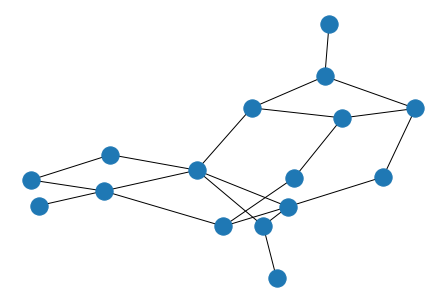

In [13]:
folder_name = f'{config["test"]["name"]}_test'
for test_idx in range(0, 10000, 10):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device)
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_model_{test_idx}_{loss}.png') 
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')

In [15]:
total = 0
for test_idx in range(1000, 10000, 10):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device)
    total += loss

In [16]:
total / 9000

0.6334822222222216

1000

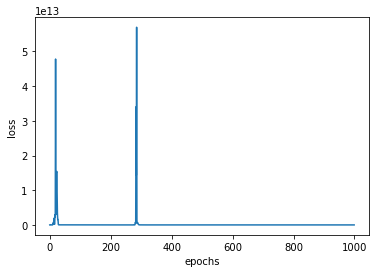

In [174]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

tensor([[0.4000, 0.2500, 2.0000],
        [1.2000, 0.0278, 2.0000],
        [0.8000, 0.0625, 2.0000],
        ...,
        [0.6000, 0.1111, 3.0000],
        [1.0000, 0.0400, 3.0000],
        [1.2000, 0.0278, 3.0000]])